In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import logging
import hydra
from matplotlib import pyplot as plt
from scipy.fft import fft2
import numpy as np
import xarray
import gnss_tid.plotting
plt.style.use("bmh")

with hydra.initialize(version_base=None, config_path="src/gnss_tid/conf", job_name="jupyter"):
    cfg = hydra.compose(config_name="config")
logging.basicConfig(level=logging.INFO)
cfg.focus.n_jobs = 1
logging.info("%s", cfg.focus.n_jobs)
points = hydra.utils.instantiate(cfg.event.pointdata)
focuser = hydra.utils.instantiate(cfg.focus)

data = xarray.open_dataset("/homes/starrgw1/code/gnss-tid/outputs/2024-12-06/04-40-08/autofocus.h5")
ti = data.objective.argmax("time").item()
slices, times = points.get_time_slices(cfg.sample.window, cfg.sample.step)
T = data.isel(time=ti)
out = focuser.run_time(points, slices[ti], times[ti], return_data=True)

INFO:root:1
INFO:gnss_tid.spectral:[082-086]: processing heights
INFO:gnss_tid.spectral:[082-086]: height = 150.0
INFO:gnss_tid.image:image boundary west: -2141.04
INFO:gnss_tid.image:image boundary south: -1264.62
INFO:gnss_tid.image:image boundary east: 2294.83
INFO:gnss_tid.image:image boundary north: 1589.72
INFO:gnss_tid.spectral:[082-086]: height = 160.0
INFO:gnss_tid.spectral:[082-086]: height = 170.0
INFO:gnss_tid.spectral:[082-086]: height = 180.0
INFO:gnss_tid.spectral:[082-086]: height = 190.0
INFO:gnss_tid.spectral:[082-086]: height = 200.0
INFO:gnss_tid.spectral:[082-086]: height = 210.0
INFO:gnss_tid.spectral:[082-086]: height = 220.0
INFO:gnss_tid.spectral:[082-086]: height = 230.0
INFO:gnss_tid.spectral:[082-086]: height = 240.0
INFO:gnss_tid.spectral:[082-086]: height = 250.0
INFO:gnss_tid.spectral:[082-086]: height = 260.0
INFO:gnss_tid.spectral:[082-086]: height = 270.0
INFO:gnss_tid.spectral:[082-086]: height = 280.0
INFO:gnss_tid.spectral:[082-086]: height = 290.0


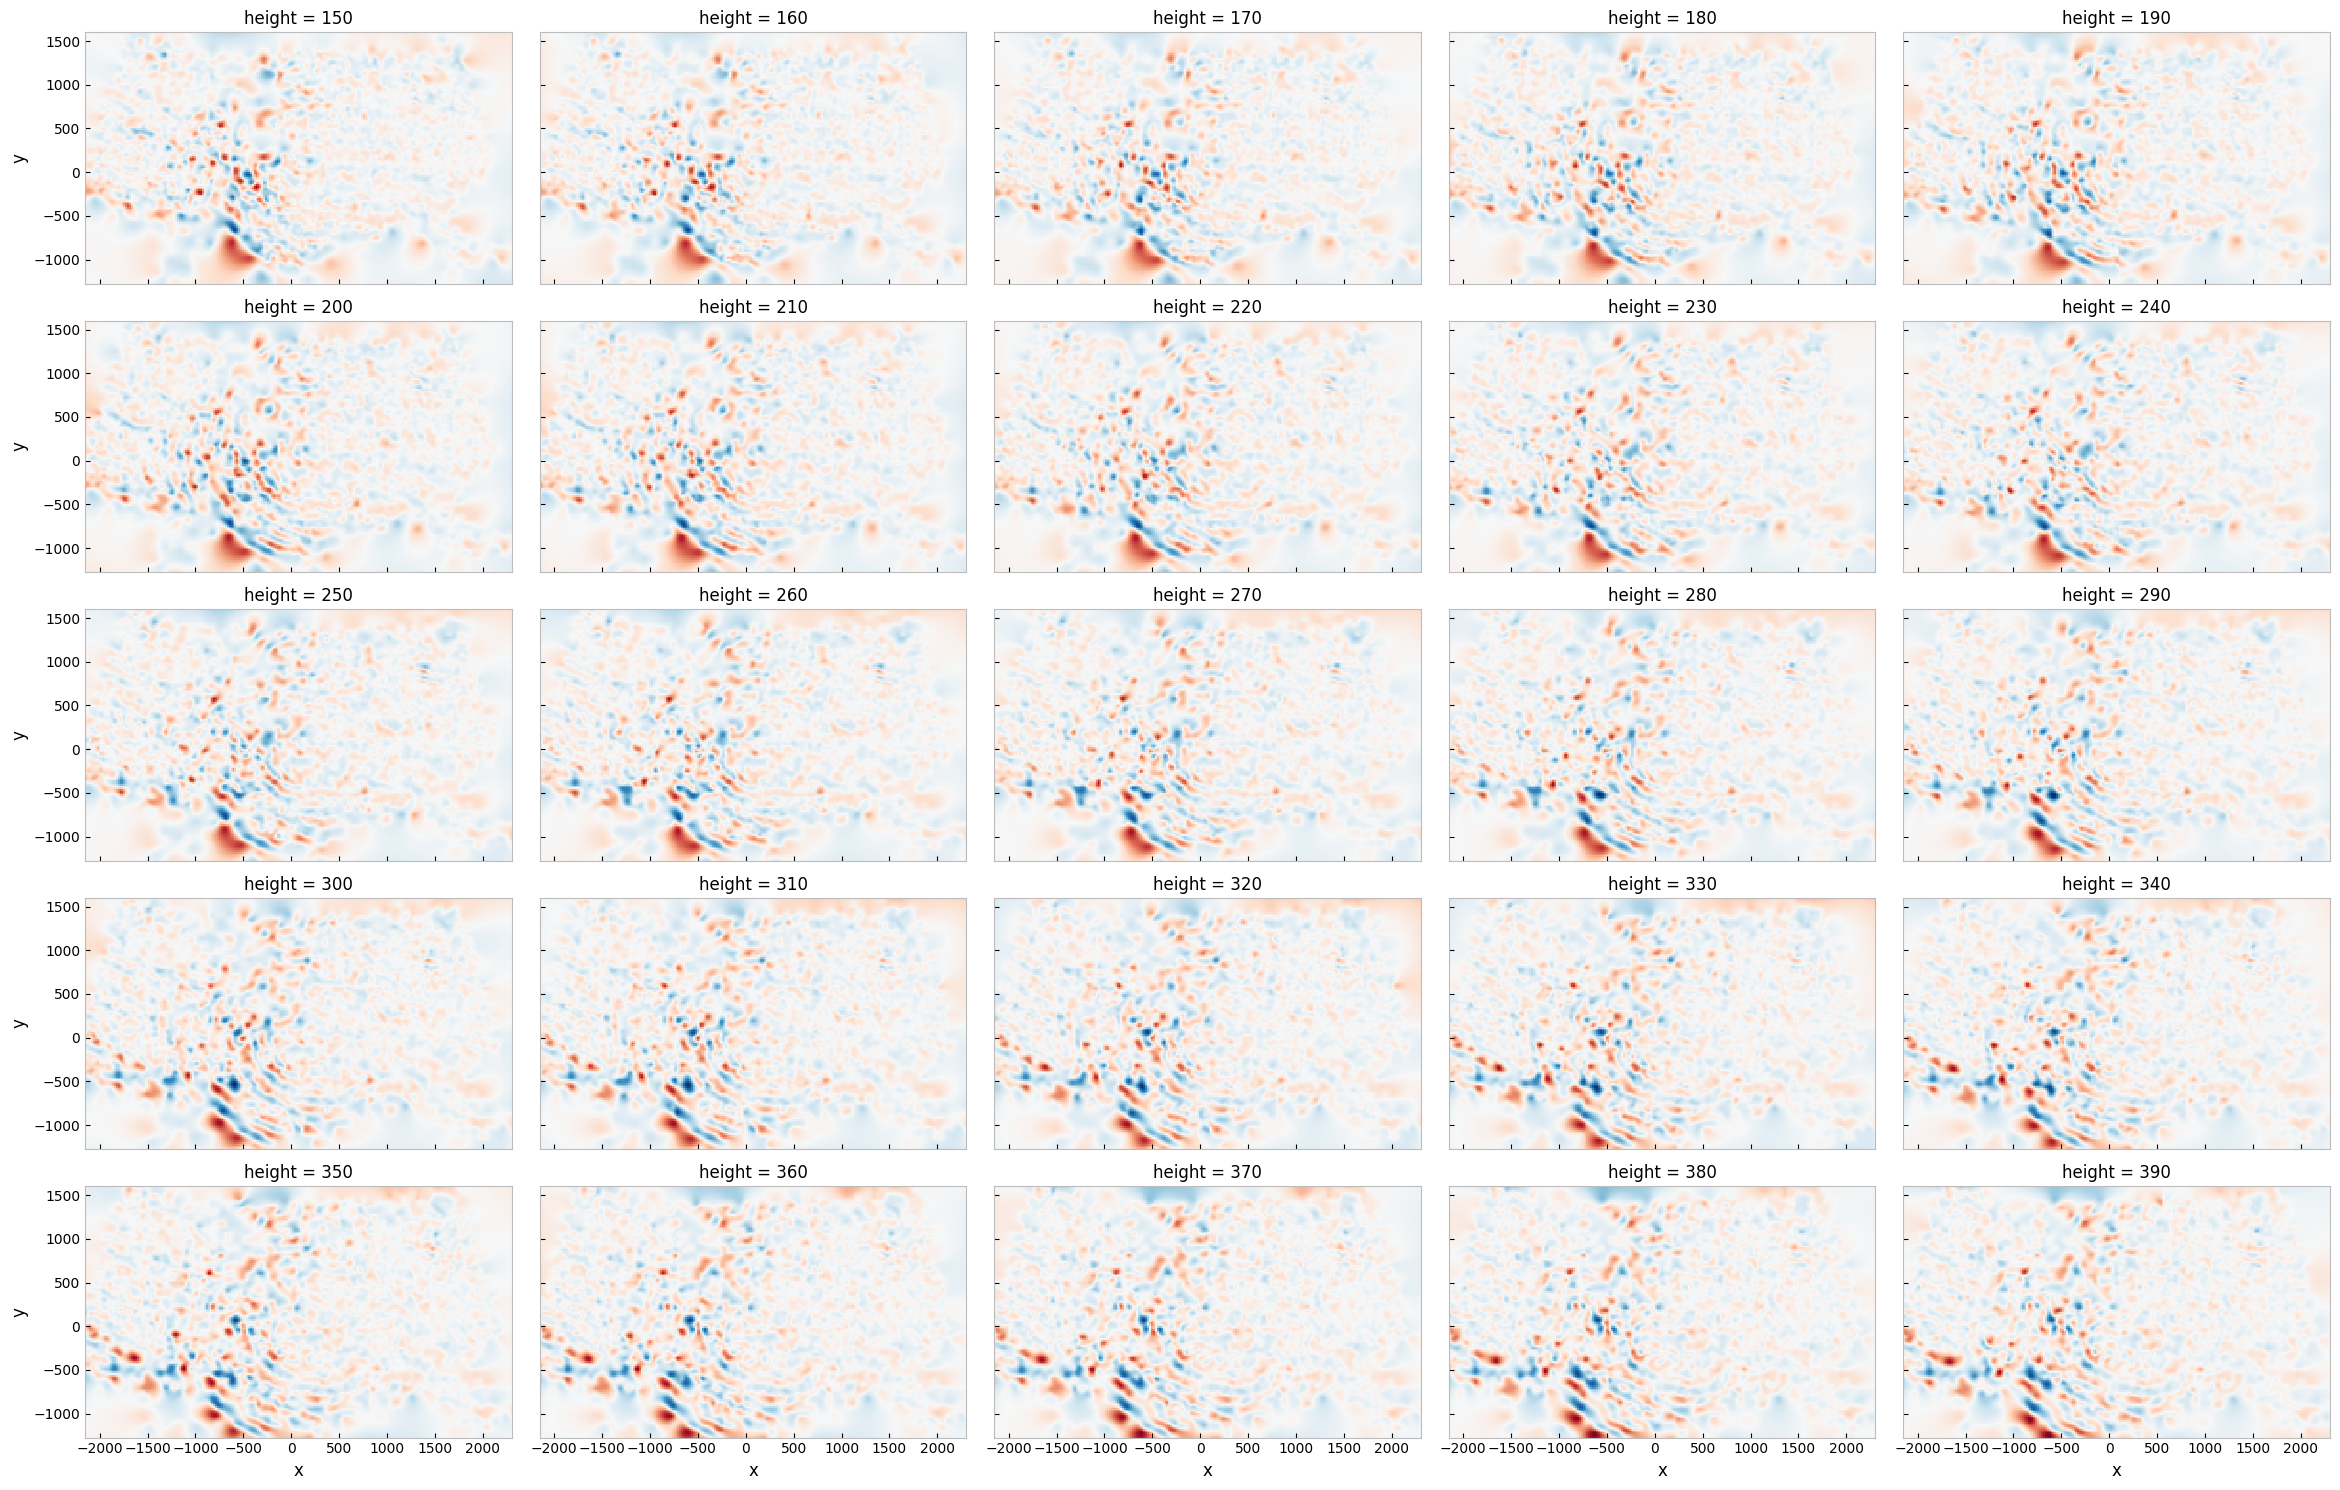

In [36]:
out.isel(time=0).image.plot(col="height", col_wrap=5, vmax=.3, size=3, aspect=1.5, add_colorbar=False)

/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xarray/plot/dataarray_plot.py:2003: UserWarning: Log scale: values of z <= 0 have been masked
  primitive = ax.contour(x, y, z, **kwargs)
/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xarray/plot/utils.py:736: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  cbar = fig.colorbar(primitive, **cbar_kwargs)


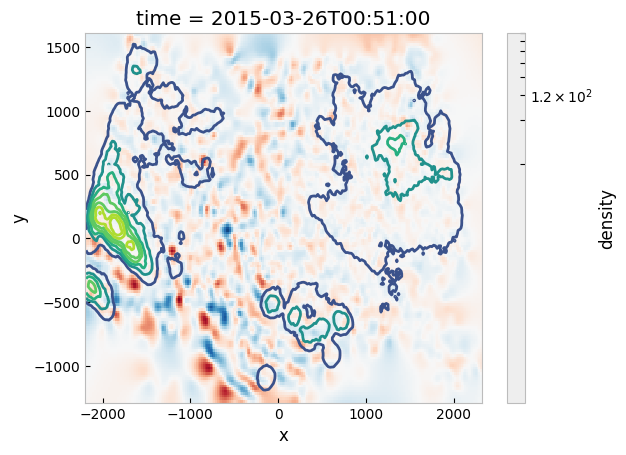

In [41]:
import gnss_tid.plotting
from matplotlib.colors import LogNorm
T.image.plot(vmax=.3, add_colorbar=False)
T.density.plot.contour(add_colorbar=True, levels=10, norm=LogNorm(20, 300))

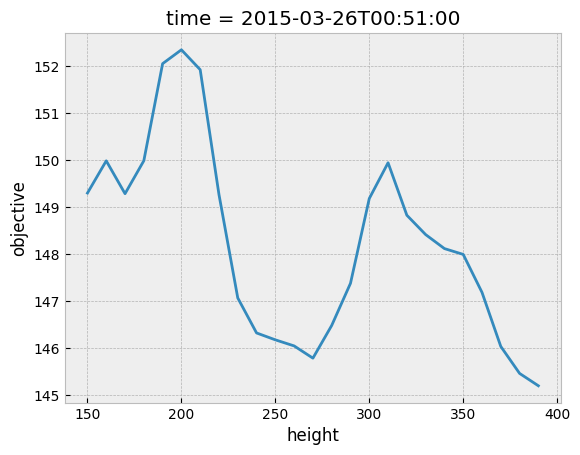

In [44]:
out.objective.plot()

lsq unweighted: [141.20516153 174.60619534], lsq weighted [ 75.48984248 165.6234549 ], grid search: [416.5791389   52.76776805]


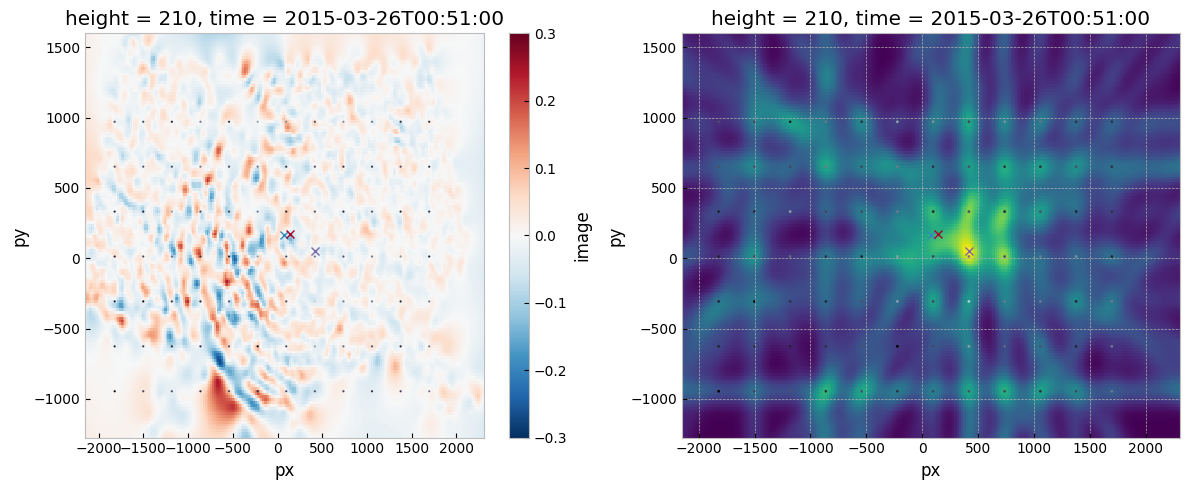

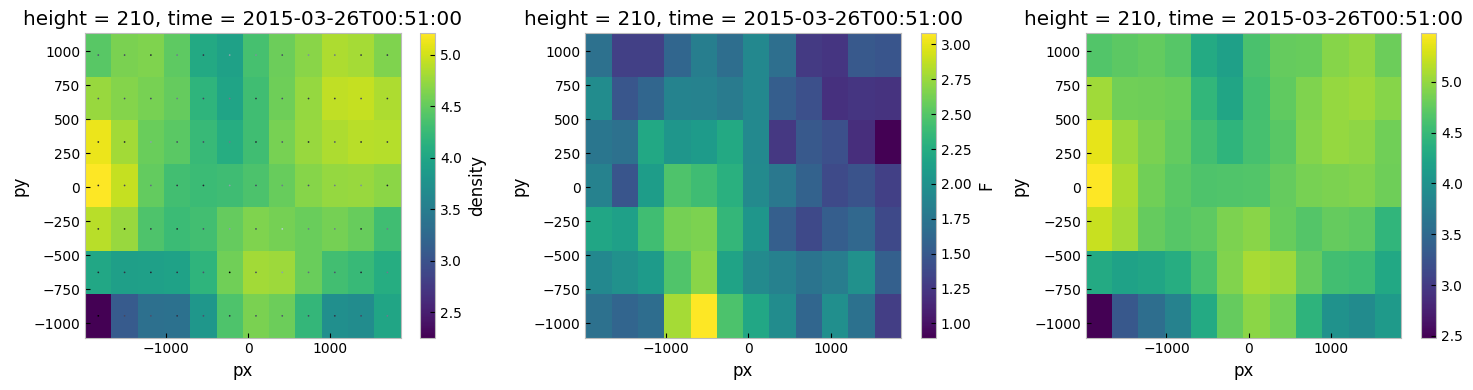

In [42]:
# height = T.height.item()
height = 210
gnss_tid.plotting.plot_center_finder(out.sel(height=height).isel(time=0))

fig, ax = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
edges = focuser.block_shape[0] // (2 * focuser.block_step)
pw = (
    out.density
    .rolling(y=focuser.block_shape[0], x=focuser.block_shape[1], center=True)
    .construct(x="kx", y="ky", stride=focuser.block_step)
    .isel(x=slice(edges, -edges), y=slice(edges, -edges))
    .rename({"x": "px", "y": "py"})
    .sum(["kx", "ky"])
)
np.log10(pw.sel(height=height)).plot(ax=ax[0])
gnss_tid.plotting.plot_patches(out.sel(height=height).isel(time=0), img=False, ax=ax[0])
out.sel(height=height).isel(time=0).F.plot(ax=ax[1])
G = np.log10(pw) + np.log10(out.F)
G.sel(height=height).plot(ax=ax[2])

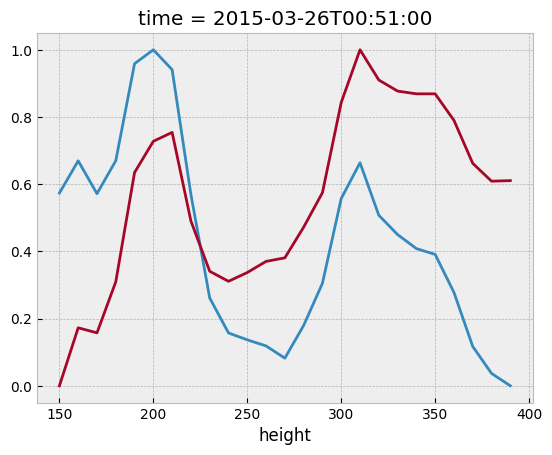

In [39]:
orig = out.objective
orig = orig - orig.min()
orig = orig / orig.max()
gob = G.sum(["px", "py"])
gob = gob - gob.min()
gob = gob / gob.max()
orig.plot()
gob.plot()

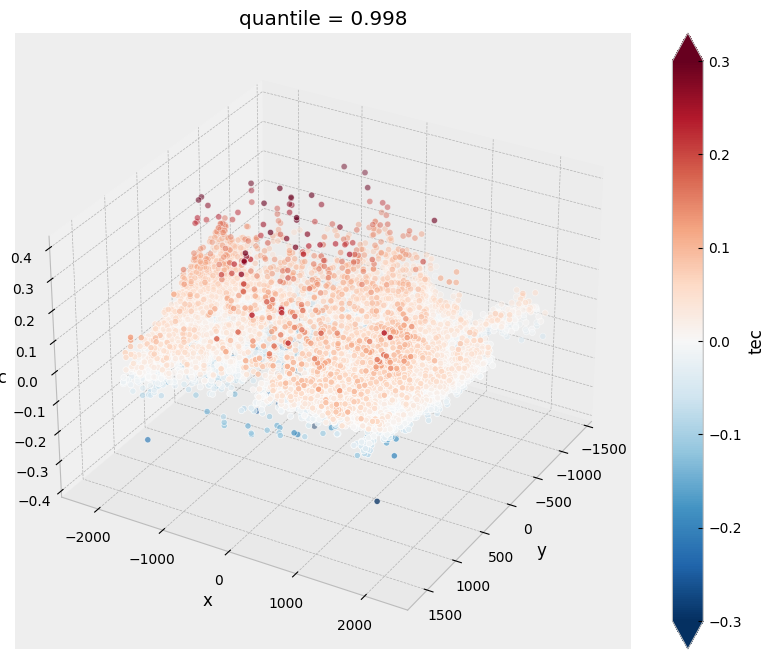

In [40]:
C = points.get_data(slices[ti], 330)
C.plot.scatter(x="x", z="y", y="tec", hue="tec", s=20, size=8, vmax=.3)